In [1]:
import ale, json, os
import ctypes
import shapely.wkt
import matplotlib.pyplot as plt

from knoten import csm, csmapi
from ale.drivers.cassini_drivers import CassiniIssPds3NaifSpiceDriver
from ale.drivers import JsonEncoder

lib = ctypes.CDLL('/home/kberry/anaconda3/envs/ALE/lib/libusgscsm.so')

In [2]:
# test image
cassini_iss_nac = '/home/kberry/dev/ale/ale/N1597182735_2.LBL'

driver = CassiniIssPds3NaifSpiceDriver(cassini_iss_nac)

# Kernels are furnished inside the with
with driver as d:
    # this is the information for the ISD in a python dict
    aledict = d.to_dict()


# Export python dictionary ISD to external json file to be used by CSM
alelabel = os.path.splitext(cassini_iss_nac)[0]+".json"
json.dump(aledict, open(alelabel, "w"), cls=JsonEncoder)


# Setup to make a csm camera model
model="USGS_ASTRO_FRAME_SENSOR_MODEL"
plugin = csmapi.Plugin.getList()[0]
isd = csmapi.Isd(alelabel)

# Use plugin to construct a camera
camera = plugin.constructModelFromISD(isd, model)

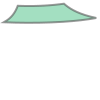

In [3]:
# ALE + CSM geometry 

nlines, nsamples = aledict["image_lines"], aledict["image_samples"]

boundary = csm.generate_boundary((nlines, nsamples))
geom = csm.generate_latlon_footprint(camera, boundary, aledict['radii']['semimajor'], aledict['radii']['semiminor'])
wkt = geom.ExportToWkt()
ale_driver_geom = shapely.wkt.loads(wkt)
ale_driver_geom.geoms[0]

# A different way to plot this: 
#lons, lats, alts = csm.generate_latlon_boundary(camera, boundary, aledict['radii']['semimajor'], aledict['radii']['semiminor'])
#plt.plot(lons, lats)

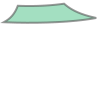

In [5]:
# ISIS geometry comparison from footprintinited cube

isis_wkt = "MULTIPOLYGON (((122.3906290586072032 -78.1126453936348497, 118.2158356648352111 -78.8134215036648840, 113.5571070026057043 -79.4517640695429321, 108.3741051997605780 -80.0178492784691855, 102.6532390415995906 -80.4997419805165322, 96.4166802696455392 -80.8848995937860593, 89.7350866963944185 -81.1612998958454313, 82.7333712200070011 -81.3189796927769208, 75.5831526789406780 -81.3516648201754151, 68.4800028057123882 -81.2579653848764991, 61.6117273546379352 -81.0416560500773357, 60.0573273563045191 -80.9696757628402679, 61.9466746857467143 -79.8842527818529646, 63.4557836440783163 -78.7982461921164798, 64.6886098503039477 -77.7122860245822409, 65.7137345892116542 -76.6274421470002238, 66.5790036571966084 -75.5442920028466318, 67.3187377131631592 -74.4631008140807040, 67.9581568951847856 -73.3839297651858544, 68.5161884494610831 -72.3067031756250742, 69.0073021716279698 -71.2312513917552081, 69.4427425160129843 -70.1573388047737012, 69.5499528455373337 -69.9056739097806030, 72.6760365305695046 -70.0119474240627824, 75.8200471465857788 -70.0647868581142177, 78.9710592743242472 -70.0640098678739349, 82.1143575486835005 -70.0096283968483419, 85.2354626137269946 -69.9020008599754874, 88.3205662617221066 -69.7418176688410654, 91.3569173371233632 -69.5300738331557682, 94.3331334654567826 -69.2680309177433315, 97.2394230275506999 -68.9571713314599464, 100.0677121171571997 -68.5991482203301928, 100.7245829879341841 -68.5122208326423987, 101.8899936491911689 -69.5131775082636238, 103.1798007147913694 -70.5056232333374311, 104.6151787154762900 -71.4894964539487177, 106.2200480867585668 -72.4632009688598373, 108.0232526240628772 -73.4246525770919192, 110.0596371140713643 -74.3711380395322692, 112.3712808464269131 -75.2991293618373021, 115.0088040819537127 -76.2040407034571246, 118.0325295871294600 -77.0799146190439330, 121.5130240633655490 -77.9190281839647980, 122.3906290586072032 -78.1126453936348497)))"
isis_geom = shapely.wkt.loads(isis_wkt)
isis_geom.geoms[0]